# Machine Learning-Driven Image Segmentation

## Table of Contents

1. [Introduction](#1--introduction)

2. [Data Clustering](#3--using-data-clustering)
    - [Image Acquisition](#2.1--image-acquisition)  
    - [Image Preprocessing](#2.2--image-preprocessing)  
    - [Feature Vector Construction](#2.3--feature-vector-construction)  
    - [Cluster Parameter Selection](#2.4--cluster-parameter-selection)  
    - [K-means Optimization](#2.5--k-means-optimization)  
    - [Cluster Label Assignment](#2.6--cluster-label-assignment)  
    - [Segmentation Mapping](#2.7--segmentation-mapping)  
    - [Result Visualization](#2.8--result-visualization)  
    - [Parameter Variation Analysis](#2.9--parameter-variation-analysis)  

3. [Data Classification](#3--using-data-classification)
    - [Image Acquisition](#3.1--image-acquisition)  
    - [Image Conversion](#3.2--image-conversion)  
    - [Binary Mask Creation](#3.3--binary-mask-creation)
    - [Feature Extraction](#3.4--feature-extraction)  
    - [Mask Flattening](#3.5--mask-flattening)  
    - [Data Splitting](#3.6--data-splitting)  
    - [ML Classifiers](#3.7--ml-classifiers)  
    - [Data Predictions](#3.8--data-predictions)  

## 1- Introduction

While the previous notebook has mostly covered rule-based image processing techniques, we will move on in this one to more sophisticated and modern ways using machine learning.

We will cover two types of techniques: **Data Clustering** and **Data Classification**, and analyze in each case the main implications and strengths.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2gray
import cv2

## 2- Using Data Clustering

## 3- Using Data Classification

### 3.1- Image Acquisition

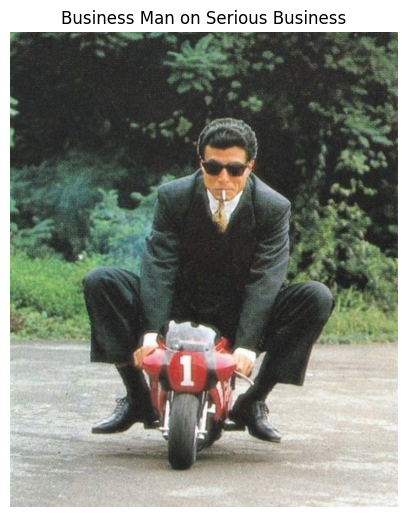

In [3]:
image = cv2.imread('data/test.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Business Man on Serious Business')
plt.show()

Using the python `opencv` library and `matplotlib` for visualization, we can see that we have on our hands a business man on serious business.

The image size as it is currently might cause problems later on when we start training, therefore it is best to resize it first before proceeding.

Original dimensions: 720x883


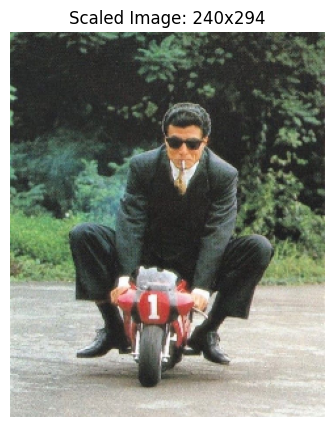

New dimensions: 240x294


In [4]:
height, width, _ = image_rgb.shape
print(f"Original dimensions: {width}x{height}")

scaled_image = cv2.resize(image_rgb, (width//3, height//3))

plt.figure(figsize=(5, 5))
plt.imshow(scaled_image)
plt.axis('off')
plt.title(f'Scaled Image: {scaled_image.shape[1]}x{scaled_image.shape[0]}')
plt.show()

image_rgb = scaled_image
print(f"New dimensions: {image_rgb.shape[1]}x{image_rgb.shape[0]}")

### 3.2- Image Conversion

It is pretty straightforward to do the image conversion using the `opencv` library, as we only need to call the default `rgb2gray` function for conversion.

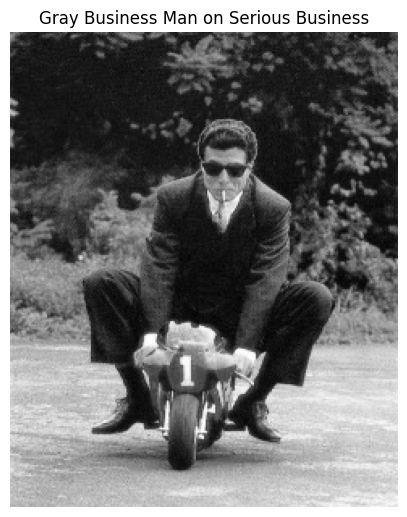

In [5]:
# convert to grascale
image = rgb2gray(image_rgb)

plt.figure(figsize=(5, 10))
# add color map to avoid it looking like a heat map
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Gray Business Man on Serious Business')
plt.show()

However, we can also go down a more customized approach using `numpy` and matrix manipulations.

We go through two steps:
- **Normalization:** First we compute the mean for each RGB value then divide the rgb image over those values
- **Customization:** The first step yields a weird lighter colored image, and so to unify it we tune the RGB values until it looks right, in our use case we went with:

    `R(0.299), G(0.587), B(0.114)`

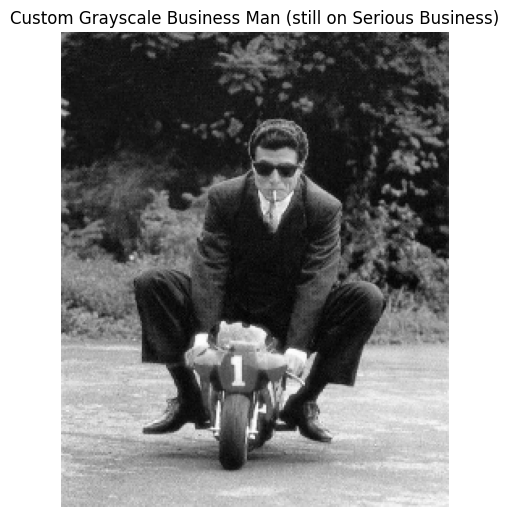

In [6]:
red = image_rgb[:, :, 0].mean()
green = image_rgb[:, :, 1].mean()
blue = image_rgb[:, :, 2].mean()

mean_value = (red + green + blue) / 3

normalized_image_rgb = image_rgb / mean_value

custom_grayscale = (normalized_image_rgb[:,:,0] * 0.299 +
                    normalized_image_rgb[:,:,1] * 0.587 +
                    normalized_image_rgb[:,:,2] * 0.114)

plt.figure(figsize=(5, 10))
plt.imshow(custom_grayscale, cmap='gray')
plt.axis('off')
plt.title('Custom Grayscale Business Man (still on Serious Business)')
plt.show()

### 3.3- Binary Mask Creation

we will try different approaches for the mask creation in order to get the most out of the image. The different methods we will be trying are:

- **Local Thresholding**: Applying threshold calculations based on local regions in the image with a small block size
- **Adjusted Local Thresholding**: Using Gaussian-weighted means with larger block size and appropriate offset based on image statistics
- **K-means Clustering**: Unsupervised learning approach to segment the image into two clusters
- **Region Growing Segmentation**: Seed-based pixel expansion based on similarity.
- **Watershed Segmentation**: Using gradients and distance transforms.
- **Gabor Filter + Thresholding**: Segmenting based on texture frequency.

In [7]:
# define all the imports we will have
from skimage.filters import threshold_local

from sklearn.cluster import KMeans

from skimage.segmentation import flood

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

from skimage.filters import gabor

# binary_masks dictionary for comparison
binary_masks = {}

In [21]:
# regular local thresholding
block_size = 21
local_thresh = threshold_local(image, offset=0.05, block_size=block_size)
binary_masks["Local Threshold"] = image > local_thresh

In [22]:
# adjusted local thresholding
img_min = np.min(image)
img_max = np.max(image)
img_mean = np.mean(image)
appropriate_offset = (img_max - img_min) * 0.1
local_thresh = threshold_local(image, block_size=21, offset=appropriate_offset, method='gaussian')
binary_masks["Adjusted Local Threshold"]= image > local_thresh

In [10]:
# KMeans clustering
flat = image.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, init='random', n_init=10).fit(flat)
clustered = kmeans.labels_.reshape(image.shape)
binary_masks["KMeans Threshold"] = clustered == clustered[0, 0]

In [54]:
#region growing segmentation
bright_coords = np.unravel_index(np.argmax(image), image.shape)
dark_coords = np.unravel_index(np.argmin(image), image.shape)

seed_point = (
    (bright_coords[0] + dark_coords[0]) // 4,
    (bright_coords[1] + dark_coords[1]) // 4
)

binary_masks["Region Growing"] = flood(image, seed_point=seed_point, connectivity=2, tolerance=0.15*(img_max - img_min))

In [61]:
# watershed segmentation
gradient = ndi.gaussian_gradient_magnitude(image, sigma=1)

# initial mask
simple_thresh = image > np.mean(image)
cleaned = ndi.binary_opening(simple_thresh, iterations=2)

# Find markers using distance transform and local maxima
distance = ndi.distance_transform_edt(cleaned)
local_maxi = peak_local_max(distance, min_distance=5, labels=cleaned)
local_maxi_mask = np.zeros(cleaned.shape, dtype=bool)
local_maxi_mask[tuple(local_maxi.T)] = True
markers = ndi.label(local_maxi_mask)[0]

watershed_labels = watershed(gradient, markers, mask=cleaned, compactness=0.1)

binary_masks["Watershed"] = watershed_labels == 0

In [30]:
# gabor + thresholding
# Apply multiple Gabor filters at different frequencies and orientations for better edge detection
frequencies = [0.05, 0.1, 0.15]
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]

gabor_composite = np.zeros_like(image)

for frequency in frequencies:
    for theta in orientations:
        filt_real, filt_imag = gabor(image, frequency=frequency, theta=theta)
        gabor_composite += np.abs(filt_real)

# Normalize composite response
gabor_composite = gabor_composite / (len(frequencies) * len(orientations))

# Apply adaptive thresholding to the Gabor response
threshold = gabor_composite.mean() + 0.4 * gabor_composite.std()
binary_masks["Gabor"] = gabor_composite > threshold

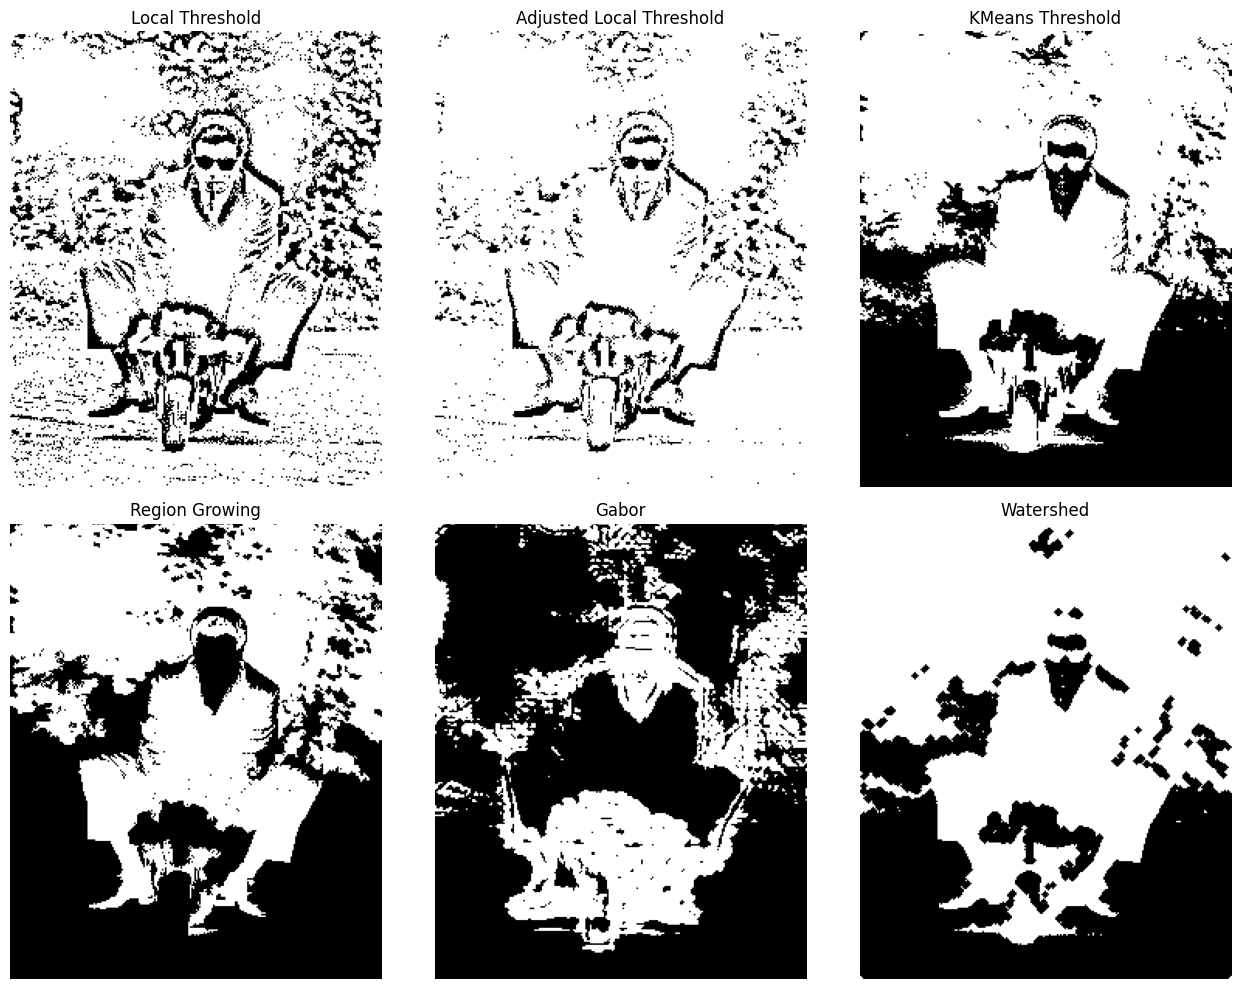

In [62]:
plt.figure(figsize=(13, 10))
for i, (name, masked) in enumerate(binary_masks.items()):
    plt.subplot(2, 3, i+1)
    plt.imshow(masked, cmap='gray')
    plt.axis('off')
    plt.title(name)
plt.tight_layout()
plt.show()

We can see here that the masks yielding the best results are `KMeans Threshold` `Region Growing` and `Watershed`. Thus we will keep only them for the final table.

In [63]:
binary_masks = {
    "KMeans Threshold": binary_masks["KMeans Threshold"],
    "Region Growing": binary_masks["Region Growing"],
    "Watershed": binary_masks["Watershed"]
}

### 3.4- Feature Extraction

Now that we have our set of masks, we can try extracting different kinds of information and features from the grayscale image and flatten the masks for labelling.

For our feature extraction, we'll create a comprehensive set of features that capture:

1. **Intensity Values**: Original pixel values to preserve basic information
2. **Local Statistics**: Mean and standard deviation in local windows to capture regional properties
3. **Edge Information**: Gradient magnitude using Sobel filters to identify boundaries
4. **Texture Information**: Gabor filters for texture characterization and Local Binary Patterns (LBP)
5. **Spatial Features**: Normalized coordinates to allow position-aware segmentation
6. **Distance Features**: Distance from image center to help with radial patterns

These features will help our classifiers distinguish between the business man and the background elements.

In [64]:
from skimage.feature import local_binary_pattern
from scipy.ndimage import uniform_filter

In [65]:
def extract_essential_features(image):
    """Extract the most important features for image segmentation"""
    # Create feature array
    features = np.zeros((image.shape[0], image.shape[1], 9))

    # 1. Original image intensity
    features[:,:,0] = image

    # 2. Local statistics (using a more efficient approach)
    window = 7
    features[:,:,1] = uniform_filter(image, window)  # Local mean
    features[:,:,2] = np.sqrt(uniform_filter(image**2, window) - features[:,:,1]**2)  # Local std

    # 3. Edge information
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    features[:,:,3] = np.sqrt(gx**2 + gy**2)  # Gradient magnitude

    # 4. Texture information (simple gabor)
    g_real, _ = gabor(image, frequency=0.1)
    features[:,:,4] = g_real

    # 5. Spatial features
    h, w = image.shape
    y_coord, x_coord = np.mgrid[0:h, 0:w]
    features[:,:,5] = y_coord / h  # Normalized y-coordinate
    features[:,:,6] = x_coord / w  # Normalized x-coordinate

    # 6. Distance from center
    cy, cx = h/2, w/2
    features[:,:,7] = np.sqrt(((y_coord-cy)/h)**2 + ((x_coord-cx)/w)**2)

    # 7. LBP for texture
    lbp = local_binary_pattern(image, 8, 1, 'default')
    features[:,:,8] = lbp

    return features

In [66]:
features = extract_essential_features(image)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


### 3.5- Mask Flattening

Now that we have our features all extracted, we can move on to flattening the masks and assigning the appropriate labels for each one based on the obtained features.

In [67]:
X_all = []
y = []

X_by_mask = {}
y_by_mask = {}
features_by_mask = {}

In [68]:
features_flat = features.reshape(-1, features.shape[2])

for name, mask in binary_masks.items():
    mask_flat = mask.reshape(-1)

    X_by_mask[name] = features_flat
    y_by_mask[name] = mask_flat
    features_by_mask[name] = features

    # append the same features for all masks for easier comparison in visualization
    X_all.append(features_flat)
    y.extend(mask_flat.astype(int))

X_all = np.vstack(X_all)
y = np.array(y)

We can now visualize the result of our labelling, according to the features we extracted.

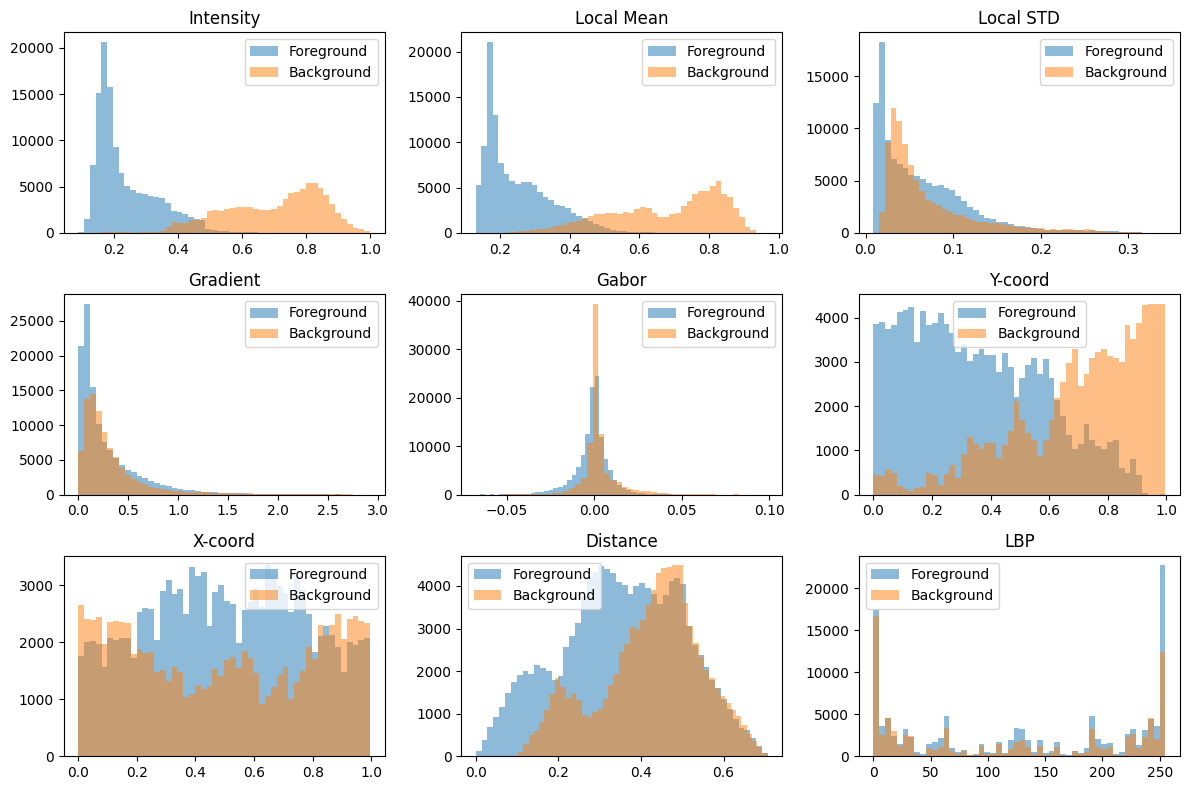

In [69]:
plt.figure(figsize=(12, 8))
feature_names = ['Intensity', 'Local Mean', 'Local STD', 'Gradient',
                'Gabor', 'Y-coord', 'X-coord', 'Distance', 'LBP']

for i in range(features.shape[2]):
    plt.subplot(3, 3, i+1)
    plt.hist(X_all[y==1, i], bins=50, alpha=0.5, label='Foreground')
    plt.hist(X_all[y==0, i], bins=50, alpha=0.5, label='Background')
    plt.title(feature_names[i])
    plt.legend()

plt.tight_layout()
plt.show()

### 3.6- Data Splitting

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_test_data = {}

for name, X in X_by_mask.items():
    y = y_by_mask[name]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    train_test_data[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
    }

### 3.7- ML Classifiers

We can now finally work on the models. We elected to expand further than just the SVM model, adding also tree based models to see what results they will give for each mask.

In [71]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


models = {
    'SVM (Linear)': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=-1)
}

In [72]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone

for mask_name, X in X_by_mask.items():
    print(f"Training models on {mask_name} mask...")
    X_train, X_test, y_train, y_test = train_test_data[mask_name].values()

    for model_name, model in models.items():
        print(f"Training with Model {model_name}..")
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)

Training models on KMeans Threshold mask...
Training with Model SVM (Linear)..
Training with Model Random Forest..
Training with Model KNN..
Training models on Region Growing mask...
Training with Model SVM (Linear)..
Training with Model Random Forest..
Training with Model KNN..
Training models on Watershed mask...
Training with Model SVM (Linear)..
Training with Model Random Forest..
Training with Model KNN..


### 3.8- Data Predictions

#### 3.8.1 Data Predictions per Model

In [73]:
results_by_mask = {}

for name, X in X_by_mask.items():
    mask_results = []
    for model_name, model in models.items():
        mask_results.append({
                    'Model': model_name,
                    'Mask': mask_name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'F1-Score': f1_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred)
                })
    results_by_mask[mask_name] = pd.DataFrame(mask_results)

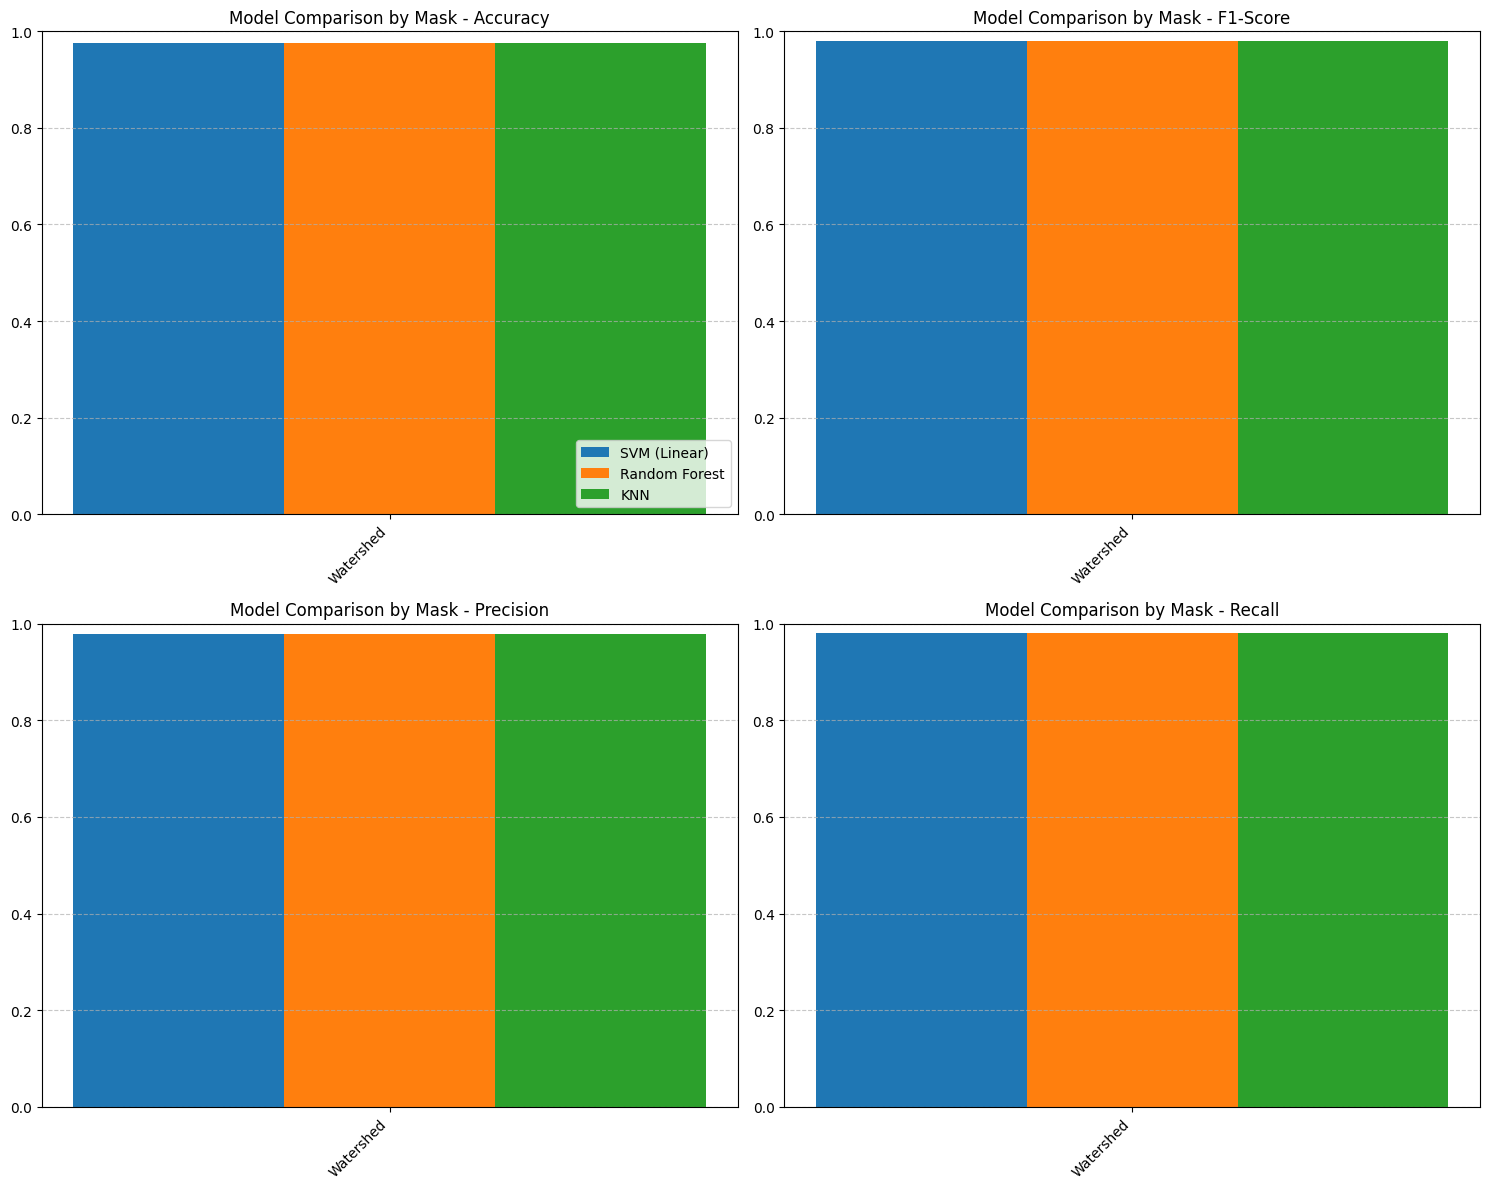

In [74]:
all_results = pd.concat(results_by_mask.values())

plt.figure(figsize=(15, 12))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)

    # For each mask, plot a group of bars (one per model)
    mask_names = all_results['Mask'].unique()
    x_positions = np.arange(len(mask_names))
    width = 0.2  # Width of bars

    # Plot bars for each model side by side
    for j, model_name in enumerate(models.keys()):
        model_results = all_results[all_results['Model'] == model_name]
        values = [model_results[model_results['Mask'] == mask][metric].values[0]
                 for mask in mask_names]
        plt.bar(x_positions + (j-1)*width, values, width=width, label=model_name)

    plt.title(f'Model Comparison by Mask - {metric}')
    plt.xticks(x_positions, mask_names, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    if i == 0:
        plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

#### 2.6.2. Image Segmentation

In [75]:
# Find the best model and mask combination based on F1-Score
all_results = pd.concat(results_by_mask.values())

# Find the best model and mask combination based on F1-Score
best_result = all_results.loc[all_results['F1-Score'].idxmax()]
best_model_name = best_result['Model']
best_mask_name = best_result['Mask']

print(f"Best performing combination - Model: {best_model_name}, Mask: {best_mask_name}")
print(f"Performance metrics: Accuracy: {best_result['Accuracy']:.4f}, F1-Score: {best_result['F1-Score']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}, Recall: {best_result['Recall']:.4f}")

# Get the original mask for comparison
original_mask = binary_masks[best_mask_name]
# Get the data for the best mask
X = X_by_mask[best_mask_name]
features = features_by_mask[best_mask_name]

Best performing combination - Model: SVM (Linear), Mask: Watershed
Performance metrics: Accuracy: 0.9758, F1-Score: 0.9805
Precision: 0.9797, Recall: 0.9812


In [76]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get the best model and make predictions
best_model = models[best_model_name]
best_model.fit(train_test_data[best_mask_name]['X_train'], train_test_data[best_mask_name]['y_train'])
predictions = best_model.predict(X_scaled)

# Reshape predictions to match the original image
segmentation_mask = predictions.reshape(image.shape)

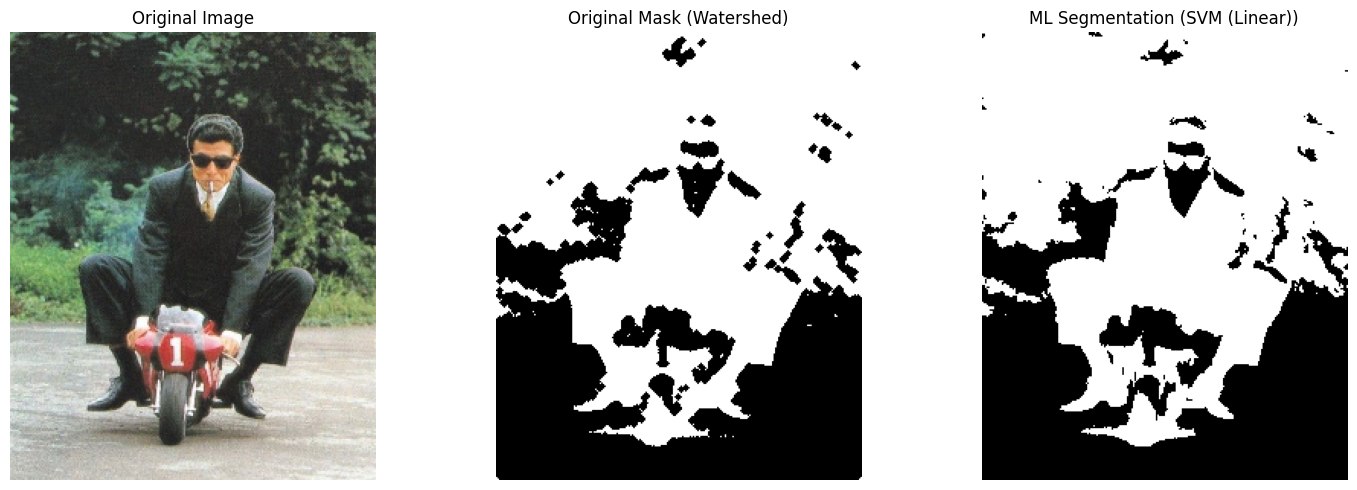

In [77]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(original_mask, cmap='gray')
plt.title(f'Original Mask ({best_mask_name})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmentation_mask, cmap='gray')
plt.title(f'ML Segmentation ({best_model_name})')
plt.axis('off')

plt.tight_layout()
plt.show()

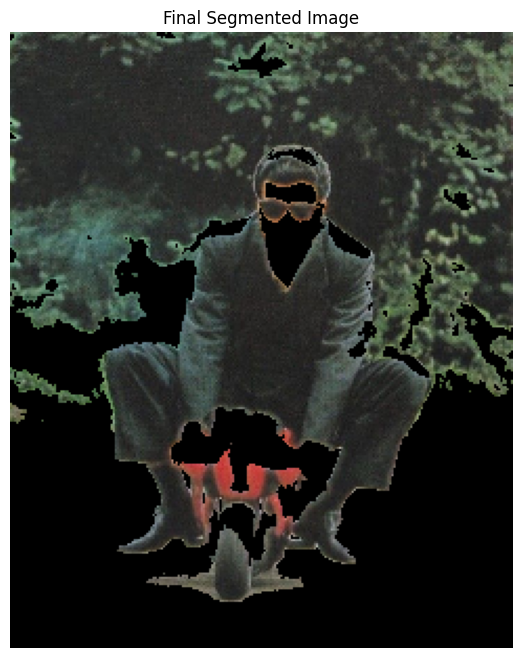

In [78]:
# Apply the segmentation mask to the original image
segmented_image = image_rgb.copy()
for c in range(3):  # RGB channels
    segmented_image[:,:,c] = segmented_image[:,:,c] * segmentation_mask

plt.figure(figsize=(10, 8))
plt.imshow(segmented_image)
plt.title('Final Segmented Image')
plt.axis('off')
plt.show()

As we can see, the segmentation is still far from perfect, but the results of the model are already quite promising, and we can see that it has adapted well to the image contents as it separated between the business man, his glasses, the foliage, and even the scooter.